In [116]:
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset, Dataset

from tqdm import tqdm
import neptune
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [117]:
#config

print(torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

os.environ["NEPTUNE_API_TOKEN"] ="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMWUxNDAwOS04NGFmLTQ1NDEtYTliYi0zOTRkYmFkOTFiNzMifQ=="

neptune_run = neptune.init_run(
    project="jayasooryantm/xai-medical-imaging",
    api_token=os.environ.get("NEPTUNE_API_TOKEN"),
)


2.5.0.dev20240619
Using device: mps
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jayasooryantm/xai-medical-imaging/e/XAIM-18


In [118]:

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [119]:
test_dir = "../chest_xray/test"


In [120]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [121]:
def dataset_validator():
    validation_status = True

    for img_path, target in test_dataset.imgs:
        if img_path.split("/")[3] == "NORMAL":
            if target == 0:
                pass # img_path == target
            else:
                validation_status = False
                print(f"\n-----CHECK THIS----- \nImage Path: {img_path}, \nTarget Value: {target}")
        if img_path.split("/")[3] == "PNEUMONIA":
            if target == 1:
                pass # img_path == target
            else:
                validation_status = False
                print(img_path, target, " ----- CHECK THIS")
    return validation_status


In [122]:
dataset_validator()


True

In [123]:
test_data_df = pd.DataFrame(test_dataset.imgs, columns=["image_path", "target"])



In [124]:
len(test_dataset)


624

In [125]:
batch_size = 128


In [126]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [127]:
print(test_loader.dataset.targets.count(0), test_loader.dataset.targets.count(1))


234 390


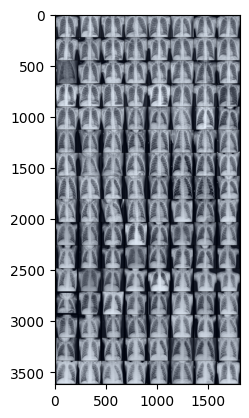

In [128]:
def imshow(img):
    img = img #/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)    
batch = next(dataiter)
images, labels = batch


imshow(torchvision.utils.make_grid(images, normalize=True))


In [129]:
class PneumoniaScannerModel(torch.nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoniaScannerModel, self).__init__()
        self.base_model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_out_ftrs = self.base_model.fc.out_features
        self.fc = torch.nn.Linear(num_out_ftrs, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = PneumoniaScannerModel().to(device)


In [130]:
model_pickle_path = "../Model/PneumoniaScannerModel.pth"


In [131]:
model.load_state_dict(torch.load(model_pickle_path))


<All keys matched successfully>

In [132]:
def evaluate(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_targets = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            targets = targets.to(device).float().view(-1, 1)
            
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Store targets and predictions
            all_targets.extend(targets.cpu().numpy().flatten())
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_probs.extend(outputs.cpu().numpy().flatten())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    cm = confusion_matrix(all_targets, all_predictions)
    cr = classification_report(all_targets, all_predictions, target_names=test_dataset.classes)
    
    test_data_df["predictions"] = all_predictions
    test_data_df["outputs"] = all_probs

    neptune_run["Testing Accuracy"] = accuracy
    neptune_run["Testing Precision"] = precision
    neptune_run["Testing Recall"] = recall
    neptune_run["Testing F1"] = f1
    

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    
    return accuracy, precision, recall, f1, cm, cr

# Evaluate the model
evaluate(model, test_loader)
neptune_run.stop()


Evaluating: 100%|██████████| 5/5 [00:48<00:00,  9.73s/it]

Accuracy: 0.8173
Precision: 0.7828
Recall: 0.9795
F1 Score: 0.8702
Confusion Matrix:
[[128 106]
 [  8 382]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.94      0.55      0.69       234
   PNEUMONIA       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.


[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/jayasooryantm/xai-medical-imaging/e/XAIM-18/metadata


Evaluating: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]

- Accuracy: 0.3157
- Precision: 0.4317
- Recall: 0.3000
- F1 Score: 0.3540
- Confusion Matrix: 

[[ 80 154]
[273 117]]

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.23      0.34      0.27       234
   PNEUMONIA       0.43      0.30      0.35       390

    accuracy                           0.32       624
   macro avg       0.33      0.32      0.31       624
weighted avg       0.35      0.32      0.32       624

In [133]:
test_data_df


,image_path,target,predictions,outputs
0,../chest_xray/test/NORMAL/IM-0001-0001.jpeg,0,1.0,0.503628
1,../chest_xray/test/NORMAL/IM-0003-0001.jpeg,0,0.0,0.100643
2,../chest_xray/test/NORMAL/IM-0005-0001.jpeg,0,0.0,0.060114
3,../chest_xray/test/NORMAL/IM-0006-0001.jpeg,0,1.0,0.798147
4,../chest_xray/test/NORMAL/IM-0007-0001.jpeg,0,0.0,0.277804
...,...,...,...,...
619,../chest_xray/test/PNEUMONIA/person96_bacteria...,1,1.0,0.894453
620,../chest_xray/test/PNEUMONIA/person96_bacteria...,1,1.0,0.777276
621,../chest_xray/test/PNEUMONIA/person97_bacteria...,1,1.0,0.999306
622,../chest_xray/test/PNEUMONIA/person99_bacteria...,1,1.0,0.997992
